# Введение в Вариационные Автоэнкодеры (VAE) на PyTorch

*Проект выполнен студентом 331 группы Ряховским Алексеем*

Этот ноутбук представляет собой подробное введение в вариационные автоэнкодеры (VAE). Я расскажу теоретические основы, математику, реализуем VAE с использованием PyTorch и обучим его на классическом наборе данных MNIST (рукописные цифры).

**Цели:**
1.  Объяснить концепцию **стандартных автоэнкодеров (AE)** как основу.
2.  Подробно разобрать **теорию VAE**: зачем они нужны, как работают, их математические основы (ELBO, репараметризационный трюк, KL-дивергенция).
3.  Реализовать модель VAE на **PyTorch**.
4.  Обучить VAE на данных **MNIST**.
5.  Продемонстрировать возможности VAE: реконструкция, визуализация латентного пространства, генерация новых данных.

<img src="images/1.png" alt="Мое изображение" style="display: block; margin-left: auto; margin-right: auto; width: 600px;">

In [1]:
# Импорт необходимых библиотек
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.utils import save_image, make_grid

import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import os
import PIL
import random

import warnings
warnings.filterwarnings("ignore")

# Для воспроизводимости результатов
torch.manual_seed(42)
np.random.seed(42)

# Создаем папку для сохранения результатов (сгенерированных картинок)
sample_dir = 'samples_vae'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

## 1. Теория - От Автоэнкодеров (AE) к Вариационным Автоэнкодерам (VAE)

### Что такое Автоэнкодер (AE)?

Прежде чем погрузиться в VAE, давайте вспомним (или узнаем) про **стандартные (или базовые) автоэнкодеры (AE)**.

**Цель AE:** Научиться сжимать данные (например, изображение) в представление меньшей размерности (латентный код) и затем восстанавливать (реконструировать) исходные данные из этого сжатого представления с минимальными потерями.

**Структура AE:**
1.  **Энкодер (Encoder):** Нейронная сеть, которая принимает входные данные $x$ и преобразует их в латентный код $z$ ($z = \text{Encoder}(x)$). Обычно $z$ имеет гораздо меньшую размерность, чем $x$.
2.  **Латентное пространство (Latent Space):** Пространство, в котором существуют векторы $z$. Его размерность - это "узкое горлышко" (bottleneck) автоэнкодера.
3.  **Декодер (Decoder):** Нейронная сеть, которая принимает латентный код $z$ и пытается восстановить исходные данные $\hat{x}$ ($\hat{x} = \text{Decoder}(z)$).

**Обучение AE:**
Модель обучается минимизировать **ошибку реконструкции** - разницу между исходным входом $x$ и восстановленным выходом $\hat{x}$. В качестве функции потерь часто используют среднеквадратичную ошибку (Mean Squared Error, MSE) или бинарную кросс-энтропию (Binary Cross-Entropy, BCE).

Формула ошибки реконструкции для Среднеквадратичной Ошибки (MSE):

$$ \large L_{AE} = ||x - \hat{x}||^2$$

Формула ошибки реконструкции для Бинарной Кросс-Энтропии (BCE):

$$ \large L_{AE} = -\sum_{i} [x_i \log(\hat{x}_i) + (1-x_i) \log(1-\hat{x}_i)]$$

**Проблема AE для генерации:**
Хотя AE хороши для сжатия и извлечения признаков, они **плохо подходят для генерации новых данных**. Проблема в том, что латентное пространство $z$ у AE обычно не имеет "хорошей" структуры. Если мы возьмем случайную точку $z$ из латентного пространства и подадим ее в декодер, результат $\hat{x}$ скорее всего будет бессмысленным шумом. Латентное пространство может быть "разреженным", с "дырами", и модель не знает, как интерполировать между известными кодами $z$.

### Вариационный Автоэнкодер (VAE): Идея

VAE решает проблему генерации, делая автоэнкодер **вероятностным**.

**Ключевое отличие:** Вместо того, чтобы энкодер отображал вход $x$ в *одну* точку $z$ в латентном пространстве, VAE энкодер отображает $x$ в **параметры вероятностного распределения** в латентном пространстве. Обычно это многомерное Гауссово распределение (нормальное распределение), которое характеризуется двумя векторами:
* **Среднее (mean):** $\mu$
* **Логарифм вариации (log-variance):** $\log \sigma^2$ (используют логарифм для численной стабильности)

То есть, $\text{Encoder}(x) = (\mu, \log \sigma^2)$. Это распределение $q(z|x)$ - наша *аппроксимация* истинного, но неизвестного апостериорного распределения $p(z|x)$.

**Сэмплирование из латентного пространства:**
Чтобы получить конкретный латентный вектор $z$ для данного $x$, мы **сэмплируем** его из распределения $\mathcal{N}(\mu, \sigma^2)$, параметры которого выдал энкодер. $z \sim q(z|x) = \mathcal{N}(z | \mu, \sigma^2)$.

**Декодер VAE:**
Работает так же, как в AE: принимает латентный вектор $z$ и генерирует реконструированный выход $\hat{x}$. $\hat{x} = \text{Decoder}(z)$. Декодер определяет распределение $p(x|z)$.

### Репараметризационный Трюк (Reparameterization Trick)

Возникает проблема: процесс сэмплирования $z \sim \mathcal{N}(\mu, \sigma^2)$ является **стохастическим (случайным)**. Стандартные методы обратного распространения ошибки (backpropagation) не могут проходить через случайные узлы. Как же обучать энкодер, если градиент не может "добраться" до $\mu$ и $\log \sigma^2$?

На помощь приходит **репараметризационный трюк**. Идея в том, чтобы выразить случайный сэмпл $z$ как **детерминированную функцию** параметров распределения ($\mu, \sigma^2$) и **независимой случайной переменной** $\epsilon$, имеющей фиксированное распределение (обычно стандартное нормальное $\mathcal{N}(0, I)$).

Для Гауссова случая:
$z = \mu + \sigma \cdot \epsilon = \mu + \exp(0.5 \cdot \log \sigma^2) \cdot \epsilon$
где $\epsilon \sim \mathcal{N}(0, I)$.

Теперь случайность "вынесена" в $\epsilon$. Путь от $\mu$ и $\log \sigma^2$ к $z$ становится детерминированным и, следовательно, **дифференцируемым**. Градиенты могут спокойно проходить через эту операцию к параметрам энкодера.

<img src="images/2.png" alt="Схема Репараметризационного Трюка" style="display: block; margin-left: auto; margin-right: auto; width: 500px;">

### Функция Потерь VAE (ELBO)

Так как, VAE - это генеративная модель. В идеале, мы хотим максимизировать правдоподобие данных $p(x)$ по всем возможным латентным переменным $z$: $$ \large p(x) = \int p(x|z) p(z) dz$$ где $p(z)$ - это априорное распределение латентных переменных (обычно $\mathcal{N}(0, I)$), а $p(x|z)$ - правдоподобие данных при заданном $z$ (моделируется декодером). Этот интеграл обычно неразрешим аналитически.

VAE используют подход вариационного вывода. Вместо максимизации $p(x)$ напрямую, максимизируется его **нижняя оценка правдоподобия (Evidence Lower Bound, ELBO)**:
<br>$$\large \log p(x) \ge \text{ELBO} = \mathbb{E}_{q(z|x)}[\log p(x|z)] - D_{KL}(q(z|x) || p(z))$$

<br>Максимизация ELBO эквивалентна минимизации **отрицательного ELBO**, которое и используется как функция потерь VAE:
<br>$$\large L_{VAE} = -\text{ELBO} = \underbrace{-\mathbb{E}_{q(z|x)}[\log p(x|z)]}_{\text{Ошибка Реконструкции}} + \underbrace{D_{KL}(q(z|x) || p(z))}_{\text{KL-дивергенция}}$$

Разберем компоненты:

1.  **Ошибка Реконструкции (Reconstruction Loss):** $ \large -\mathbb{E}_{q(z|x)}[\log p(x|z)]$
    * Это ожидаемое (среднее) отрицательное логарифмическое правдоподобие реконструкции. Оно измеряет, насколько хорошо декодер ($p(x|z)$) восстанавливает входные данные $x$ после того, как они были закодированы ($q(z|x)$) и сэмплированы ($z$).
    * На практике, для одного сэмпла $z$ из $q(z|x)$ для данного $x$, это просто $-\log p(x|z)$.
    * Если мы предполагаем, что пиксели изображения $x$ независимы и имеют распределение Бернулли (вероятность быть белым = $\hat{x}_i$), то этот член превращается в **Бинарную Кросс-Энтропию (BCE)** между $x$ и $\hat{x} = \text{Decoder}(z)$.
    * Если предположить Гауссово распределение $p(x|z)$, то получится **Среднеквадратичная Ошибка (MSE)**. Для MNIST с пикселями в [0, 1] обычно используют BCE.
    * Формула BCE: $ L_{recon} = -\sum_{i=1}^{D} [x_i \log(\hat{x}_i) + (1-x_i) \log(1-\hat{x}_i)]$, где $D$ - размерность $x$.<br>
    `
2.  **KL-дивергенция (Kullback–Leibler Divergence):** $\large D_{KL}(q(z|x) || p(z))$

    * Это мера "расстояния" или "различия" между распределением, которое выдает энкодер ($q(z|x) = \mathcal{N}(\mu, \sigma^2)$), и априорным распределением ($p(z) = \mathcal{N}(0, I)$).
    * Этот член действует как **регуляризатор**. Он заставляет энкодер генерировать распределения $q(z|x)$, близкие к стандартному нормальному. Это нужно для двух вещей:
        * **Организация латентного пространства:** Чтобы пространство было "заполнено" и точки для похожих $x$ были близки.
        * **Возможность генерации:** Чтобы мы могли сэмплировать $z$ напрямую из $p(z) = \mathcal{N}(0, I)$ и получать осмысленные результаты от декодера.
    * Для двух Гауссовых распределений $q(z|x) = \mathcal{N}(\mu, \sigma^2)$ и $p(z) = \mathcal{N}(0, I)$, <br> KL-дивергенция вычисляется аналитически:
        $$ \large D_{KL} = -0.5 \sum_{j=1}^{J} (1 + \log(\sigma_j^2) - \mu_j^2 - \sigma_j^2)$$
        где $J$ - размерность латентного пространства, $\mu_j$ и $\sigma_j^2$ - компоненты векторов $\mu$ и $\sigma^2$.

**Итог:** VAE обучается одновременно хорошо реконструировать данные и поддерживать структуру латентного пространства близкой к стандартному нормальному распределению. Это позволяет ему не только сжимать данные, но и генерировать новые.

## 2. Загрузка и подготовка данных MNIST (PyTorch)

In [6]:
# Параметры данных и обучения
batch_size = 128
image_size = 28*28 # 784
z_dim = 64         # Размерность латентного пространства 
learning_rate = 1e-3
image_channels = 1 

# Загрузка MNIST
dataset = datasets.MNIST(root='data',
                         train=True,
                         transform=transforms.ToTensor(), # Преобразует в тензор и [0,1]
                         download=True)

data_loader = DataLoader(dataset=dataset,
                         batch_size=batch_size,
                         shuffle=True)

# Пример батча
# data_iter = iter(data_loader)
# images, labels = next(data_iter)
# print('Tensor shape:', images.shape) # torch.Size([128, 1, 28, 28])
# print('Min pixel value:', images.min())
# print('Max pixel value:', images.max())

# Определяем устройство (GPU если доступно, иначе CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## 3. Построение модели VAE (PyTorch)

Создадим класс `VAE`, наследуемый от `torch.nn.Module`. Он будет содержать:
* Энкодер: Несколько сверточных слоев с LeakyReLU активацией. Последний слой разделится на два для вывода $\mu$ и $\log \sigma^2$.
* Функцию репараметризации.
* Декодер: Несколько сверточных слоев с LeakyReLU, и последний слой с Sigmoid активацией, чтобы выходные пиксели были в диапазоне [0, 1].

In [7]:
#  Определение Модели ConvVAE 
class ConvVAE(nn.Module):
    def __init__(self, image_channels=1, z_dim=32):
        super(ConvVAE, self).__init__()
        self.z_dim = z_dim
        # Количество каналов после последнего сверточного слоя энкодера
        self.encoder_output_channels = 512
        # Размер выхода энкодера после Flatten (т.к. выход 1x1)
        self.encoder_output_flat_size = self.encoder_output_channels

        self.encoder = nn.Sequential(
            # Input: (N, 1, 28, 28)
            nn.Conv2d(image_channels, 64, kernel_size=4, stride=2, padding=1), # -> (N, 64, 14, 14)
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1), # -> (N, 128, 7, 7)
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=0), # K=3,S=2,P=0: 7 -> 3 -> (N, 256, 3, 3)
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, self.encoder_output_channels, kernel_size=3, stride=1, padding=0), # K=3,S=1,P=0: 3 -> 1 -> (N, output_channels, 1, 1)
            nn.BatchNorm2d(self.encoder_output_channels),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Flatten() # -> (N, 512)
        )

        self.fc_mu = nn.Linear(self.encoder_output_flat_size, z_dim)
        self.fc_logvar = nn.Linear(self.encoder_output_flat_size, z_dim)
        self.decoder_fc = nn.Linear(z_dim, self.encoder_output_flat_size)

        self.decoder = nn.Sequential(
            # Reshape до (N, 512, 1, 1) происходит в методе decode
            nn.ConvTranspose2d(self.encoder_output_channels, 256, kernel_size=3, stride=1, padding=0), # K3,S1,P0: 1->3 -> (N, 256, 3, 3)
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=0, output_padding=1), # K3,S2,P0,OP1: 3->7 -> (N, 128, 7, 7)
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1), # K4,S2,P1: 7->14 -> (N, 64, 14, 14)
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose2d(64, image_channels, kernel_size=4, stride=2, padding=3), # K4,S2,P1: 14->28 -> (N, 1, 28, 28)
            nn.Sigmoid() # Выходные пиксели в [0, 1]
        )

    def encode(self, x):
        h = self.encoder(x)
        mu = self.fc_mu(h)
        log_var = self.fc_logvar(h)
        return mu, log_var

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = self.decoder_fc(z)
        h = h.view(-1, self.encoder_output_channels, 1, 1) # Reshape перед ConvTranspose2d
        x_reconstructed = self.decoder(h)
        return x_reconstructed

    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        x_reconstructed = self.decode(z)
        return x_reconstructed, mu, log_var

# Функция Потерь
def loss_function(recon_x, x, mu, log_var):
    # BCE требует выпрямленных входов одинакового размера
    BCE = F.binary_cross_entropy(recon_x.view(-1, 1*28*28),
                                 x.view(-1, 1*28*28),
                                 reduction='sum')
    # KL дивергенция
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return BCE + KLD


# Создание Модели и Оптимизатора
print("Создание модели и оптимизатора...")
model = ConvVAE(image_channels=image_channels, z_dim=z_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
print("--- Структура Модели ---")
print(model)
print("------------------------")
print("Модель и оптимизатор созданы.")


Создание модели и оптимизатора...
--- Структура Модели ---
ConvVAE(
  (encoder): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2))
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
    (10): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.2, inplace=True)
    (12): Flatten(start_dim=1, end_dim=-1)
  )
  (fc_mu): Line

## 4. Обучение модели VAE (PyTorch)

Теперь напишем цикл обучения. На каждой эпохе мы будем итерироваться по `DataLoader`, выполнять прямой проход, вычислять потери, выполнять обратное распространение ошибки и обновлять веса модели.

In [23]:
# Цикл обучения
num_epochs = 25

print(f"Запуск обучения на {num_epochs} эпох...")
model.train() # Переводим модель в режим обучения
total_steps = len(data_loader)

for epoch in range(num_epochs):
    epoch_loss = 0.0

    for i, (x, _) in enumerate(data_loader):
        x = x.to(device) # Перемещаем на устройство, сохраняя форму (N, 1, 28, 28)

        # Прямой проход
        try:
            recon_x, mu, log_var = model(x)
        except Exception as e:
             print(f"\n!!! Ошибка во время прямого прохода: Эпоха {epoch+1}, Шаг {i+1} !!!")
             print(f"    Форма входа x: {x.shape}")
             print(f"    Тип объекта model: {type(model)}")
             print(f"    Сообщение об ошибке: {e}")
             raise e # Перевыбрасываем ошибку для полного traceback

        # Расчет потерь с помощью функции
        loss = loss_function(recon_x, x, mu, log_var)

        # Обратное распространение и оптимизация
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Накопление общей потери для статистики эпохи
        epoch_loss += loss.item()

        # Логирование каждые N шагов
        if (i + 1) % 100 == 0:
             # Выводим общую потерю на батч (усредненную по размеру батча)
            current_loss_per_item = loss.item() / x.size(0)
            print(f'Эпоха [{epoch+1}/{num_epochs}], Шаг [{i+1}/{total_steps}], Потеря: {current_loss_per_item:.4f}')

    # Логирование в конце эпохи
    # Убедимся, что dataset загружен
    if 'dataset' in locals() and dataset is not None and len(dataset) > 0:
        avg_epoch_loss = epoch_loss / len(dataset)
        print(f'====> Эпоха: {epoch+1} завершена')
   


    # Cохранение примеров каждые 5 эпох
    if (epoch + 1) % 5 == 0:
        print(f"Сохранение примеров для эпохи {epoch+1}...")
        model.eval() # Режим оценки
        with torch.no_grad():
            # Пример реконструкции (используем последний батч x и recon_x)
            if 'x' in locals() and 'recon_x' in locals():
                try:
                    n_examples = 8
                    orig_imgs = x[:n_examples].cpu()
                    recon_imgs = recon_x[:n_examples].cpu()
                    comparison = torch.cat([orig_imgs, recon_imgs], dim=0)
                    grid = make_grid(comparison, nrow=n_examples)
                    save_image(grid, os.path.join(sample_dir, f'reconstruction_epoch_{epoch+1}.png'))
                    print(f"Сохранены примеры реконструкции.")
                except Exception as e:
                    print(f"Ошибка при сохранении реконструкции: {e}")

            # Пример генерации
            try:
                z_sample = torch.randn(64, z_dim).to(device) # Генерируем 64 примера
                generated_imgs = model.decode(z_sample).cpu()
                grid = make_grid(generated_imgs.view(64, 1, 28, 28), nrow=8)
                save_image(grid, os.path.join(sample_dir, f'sample_epoch_{epoch+1}.png'))
                print(f"Сохранены сгенерированные примеры.")
            except Exception as e:
                 print(f"Ошибка при генерации/сохранении примеров: {e}")

        model.train() # Возвращаем режим обучения

print("\nОбучение завершено!")

Шаг 1: Сбор латентных представлений из тестового набора...
Сбор завершен. Собрано 10000 представлений.
Размер all_mus: torch.Size([10000, 64])


In [11]:
torch.save(model, "model.pth")

In [8]:
model = torch.load("model.pth", weights_only=False)

## 5. Демонстрация возможностей VAE (после обучения)

Теперь, когда модель обучена, давайте еще раз посмотрим на результаты реконструкции и генерации, а также визуализируем латентное пространство.

### 5.1 Реконструкция изображений (цифры из датасета)

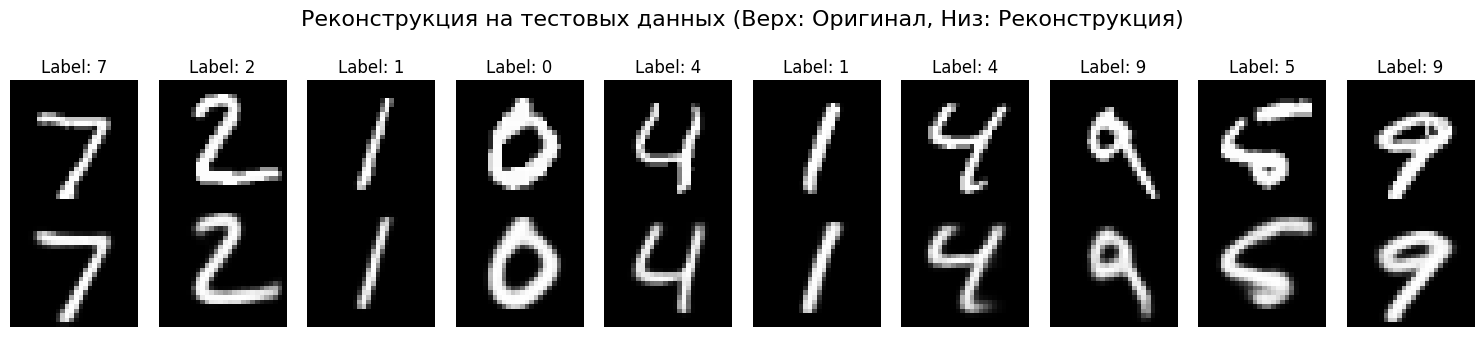

In [9]:
# Загрузим тестовый набор данных
test_dataset = datasets.MNIST(root='data', train=False, transform=transforms.ToTensor())
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# Возьмем один батч из тестового набора
model.eval() # Режим оценки
with torch.no_grad():
    test_iter = iter(test_loader)
    x_test, y_test = next(test_iter) # Получаем батч изображений и меток
    x_test_on_device = x_test.to(device)

    # Получаем реконструкции, подавая 4D тензор в модель
    recon_test, _, _ = model(x_test_on_device) # mu, log_var нам здесь не нужны

    n_examples = 10
    originals = x_test[:n_examples].view(-1, 1, 28, 28)
    recons = recon_test[:n_examples].view(-1, 1, 28, 28).cpu()

    fig, axes = plt.subplots(2, n_examples, figsize=(15, 3.5))
    fig.suptitle("Реконструкция на тестовых данных (Верх: Оригинал, Низ: Реконструкция)", fontsize=16)
    for i in range(n_examples):
        # Оригинал
        axes[0, i].imshow(originals[i, 0].numpy(), cmap='gray')
        axes[0, i].set_title(f"Label: {y_test[i].item()}")
        axes[0, i].axis('off')
        # Реконструкция
        axes[1, i].imshow(recons[i, 0].numpy(), cmap='gray')
        axes[1, i].axis('off')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

### 5.2 Визуализация латентного пространства

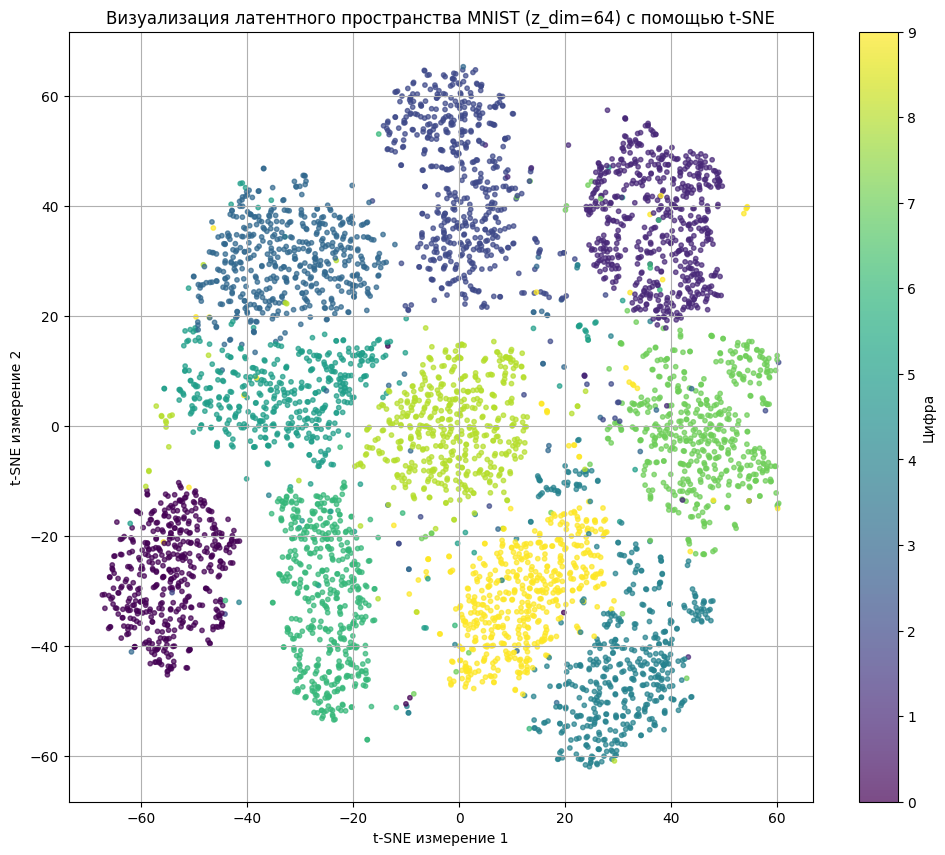

In [12]:
model.eval() # Переводим модель в режим оценки
latent_means = []
labels = []
n_samples_for_viz = 5000 # Ограничим кол-во точек для ускорения t-SNE

with torch.no_grad(): # Отключаем расчет градиентов
    count = 0
    for i, (x, y) in enumerate(test_loader): # Используем test_loader, созданный ранее
        if count >= n_samples_for_viz:
            break
        x = x.to(device) # Форма (N, 1, 28, 28)
        mu, _ = model.encode(x) # Нам нужен только mu, форма (N, z_dim)
        latent_means.append(mu.cpu().numpy())
        labels.append(y.numpy())
        count += x.size(0)

latent_means = np.concatenate(latent_means, axis=0)
labels = np.concatenate(labels, axis=0)

# Убедимся, что взяли не больше n_samples_for_viz
latent_means = latent_means[:n_samples_for_viz]
labels = labels[:n_samples_for_viz]

# Инициализируем и применяем t-SNE
# n_components=2: Снижаем до 2 измерений для визуализации
# random_state: Для воспроизводимости.
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(latent_means)

# Создаем 2D график результатов t-SNE
plt.figure(figsize=(12, 10))
scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=labels, cmap='viridis', s=10, alpha=0.7)
plt.colorbar(scatter, label='Цифра')
plt.xlabel("t-SNE измерение 1")
plt.ylabel("t-SNE измерение 2")
plt.title(f"Визуализация латентного пространства MNIST (z_dim={z_dim}) с помощью t-SNE")
plt.grid(True)
plt.show()

### 5.3 Генерация новых изображений (неосмысленная)

Сэмплируем случайные векторы $z$ из априорного распределения $\mathcal{N}(0, I)$ и подаем их на вход декодеру для генерации новых цифр.

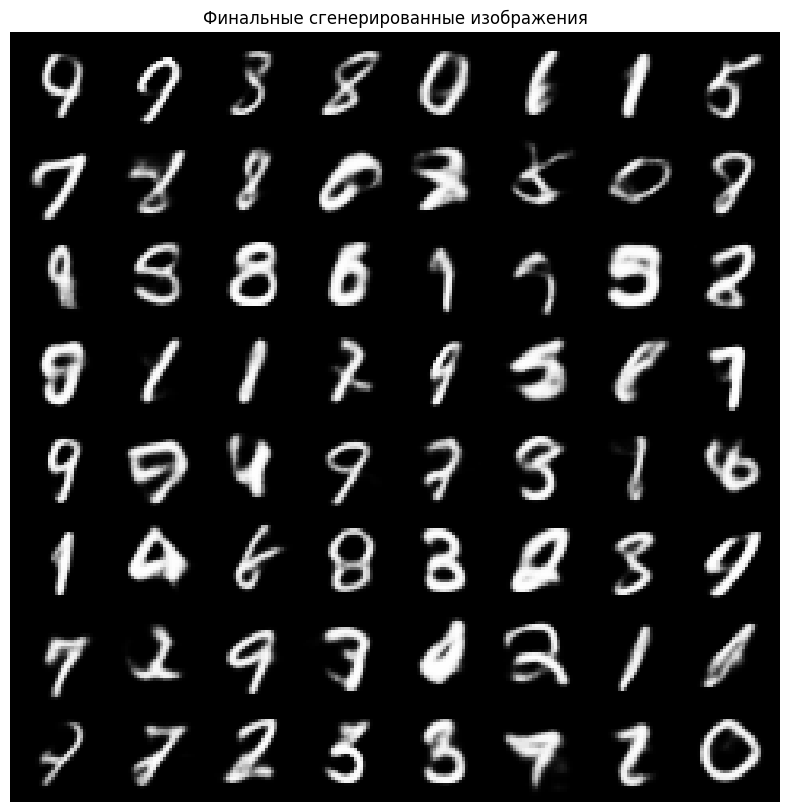

In [11]:
# Генерация новых цифр
model.eval()
with torch.no_grad():
    # Сэмплируем z из стандартного нормального распределения
    z_sample = torch.randn(64, z_dim).to(device) # Сгенерируем 64 примера
    
    # Декодируем в изображения
    generated_images = model.decode(z_sample).cpu()
    grid_final = make_grid(generated_images.view(64, 1, 28, 28), nrow=8)

    plt.figure(figsize=(10, 10))
    plt.imshow(grid_final.permute(1, 2, 0)) # Меняем оси для Matplotlib (C, H, W) -> (H, W, C)
    plt.title("Финальные сгенерированные изображения")
    plt.axis('off')
    plt.show()

### 5.3 Генерация новых изображений (осмысленная)

Сэмплируем среднее векторов $z$ с одинаковыми метками и подаем их на вход декодеру для генерации новых цифр.

Сбор завершен. Собрано 10000 изображений из test_loader.
  Генерация для цифры 0...
  Генерация для цифры 1...
  Генерация для цифры 2...
  Генерация для цифры 3...
  Генерация для цифры 4...
  Генерация для цифры 5...
  Генерация для цифры 6...
  Генерация для цифры 7...
  Генерация для цифры 8...
  Генерация для цифры 9...
Генерация всех вариантов завершена.
Отображение результатов...


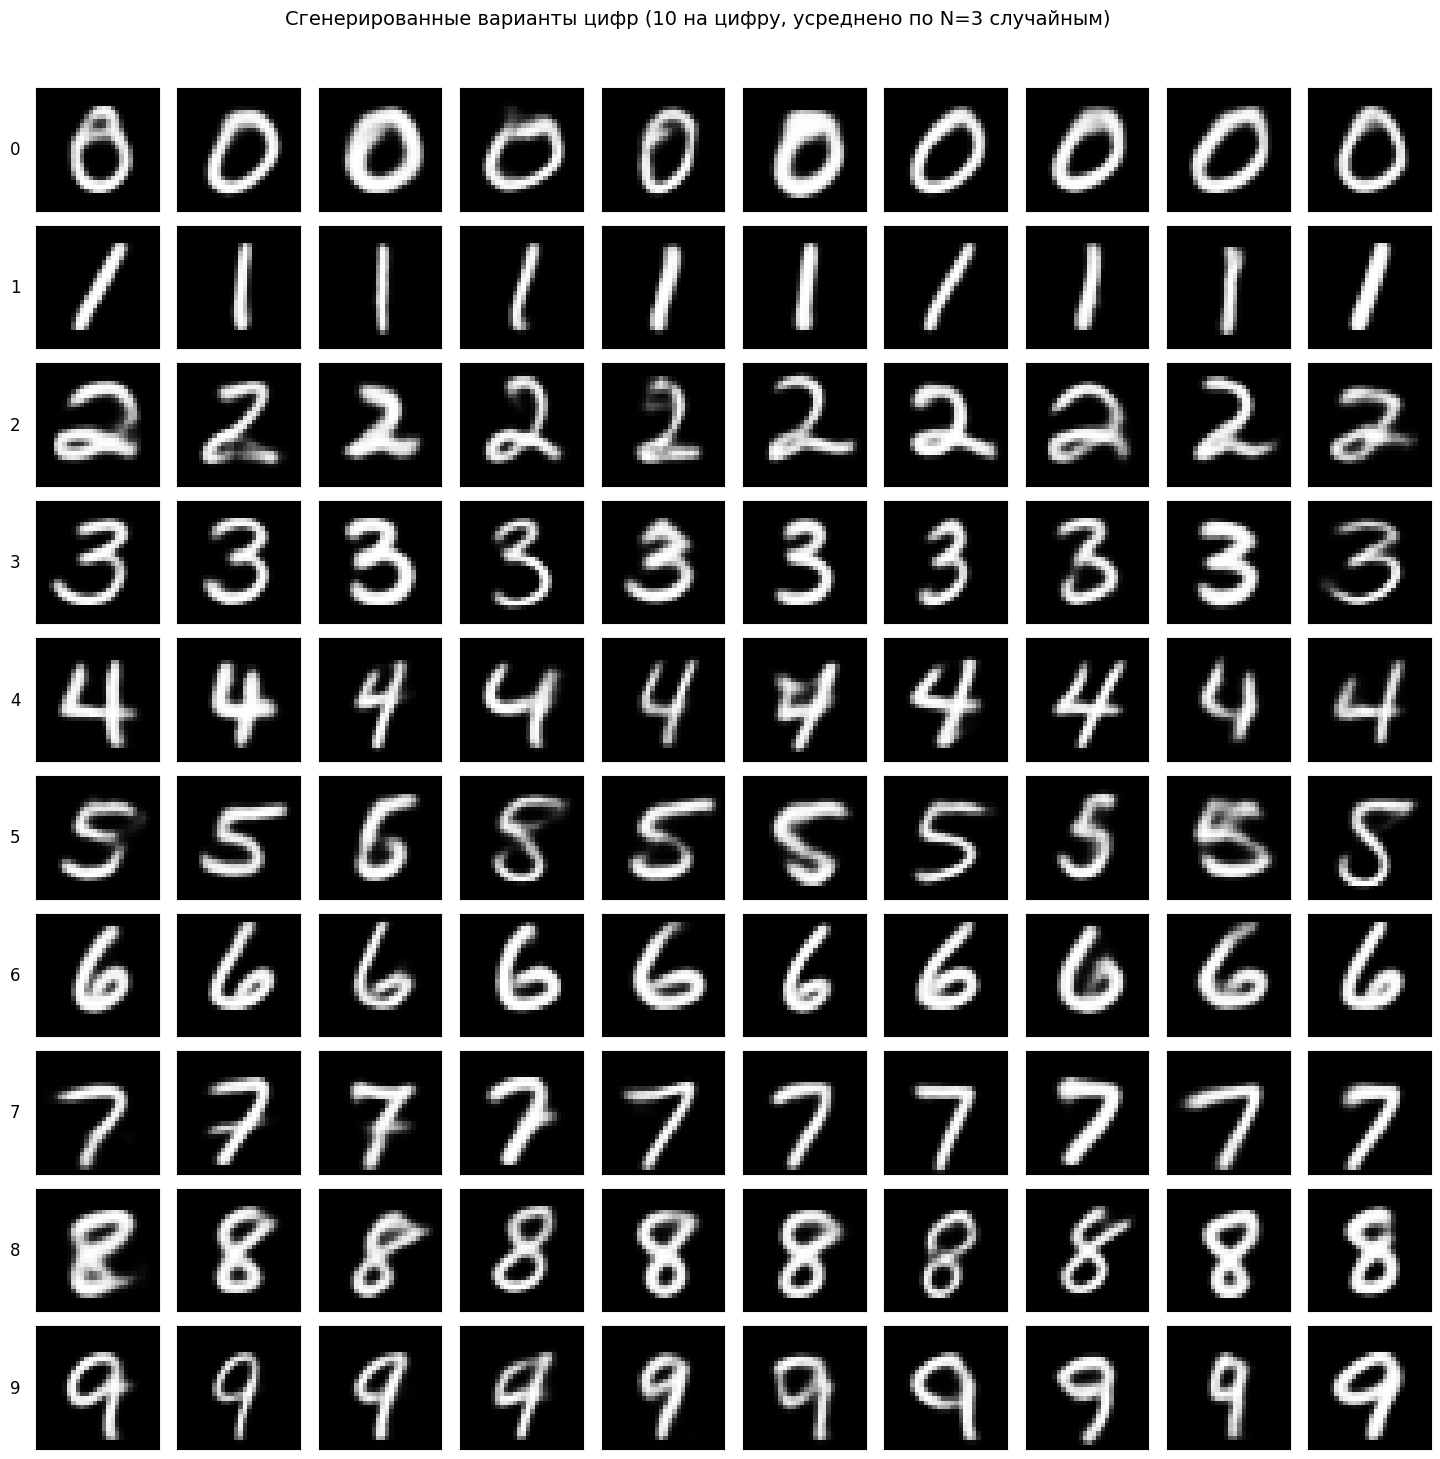

In [16]:
# Параметры Генерации 
num_classes = 10
samples_per_class_M = 10  # СКОЛЬКО ВАРИАНТОВ генерировать для каждой цифры
subset_size_for_avg_N = 3  # ПО СКОЛЬКИМ случайным реальным примерам считать среднее


all_images_list = []
all_labels_list = []
COLLECTION_DONE = False
if PROCEED:
    model.eval() # Модель нужна только для encode/decode позже
    try:
        with torch.no_grad(): # Не считаем градиенты при сборе данных
            for images, labels in test_loader:
                # Сохраняем на CPU, чтобы не занимать память GPU
                all_images_list.append(images.cpu())
                all_labels_list.append(labels.cpu())

        # Объединяем в единые тензоры
        all_images_tensor = torch.cat(all_images_list, dim=0)
        all_labels_tensor = torch.cat(all_labels_list, dim=0)
        print(f"Сбор завершен. Собрано {all_images_tensor.shape[0]} изображений из test_loader.")
        COLLECTION_DONE = True
    except Exception as e:
        print(f"Ошибка при сборе данных из test_loader: {e}")

if PROCEED and COLLECTION_DONE:
    generated_images_all = [] # Список для всех M*10 картинок

    model.eval() # Убедимся, что модель в режиме оценки

    for target_digit in range(num_classes):
        print(f"  Генерация для цифры {target_digit}...")
        # Находим все индексы для текущей цифры в собранном all_labels_tensor
        indices = (all_labels_tensor == target_digit).nonzero(as_tuple=True)[0]

        # Проверяем, достаточно ли у нас примеров для выбора N=3
        if len(indices) < subset_size_for_avg_N:
            print(f"    Предупреждение: Найдено только {len(indices)} < {subset_size_for_avg_N} примеров для цифры {target_digit}. Пропуск этой цифры.")
            # Добавляем M пустых заглушек (черных квадратов) в результат
            generated_images_all.extend([torch.zeros(1, 28, 28)] * samples_per_class_M)
            continue # Переходим к следующей цифре

        generated_this_digit = []
        # --- Внутренний цикл: генерируем M=5 вариантов ---
        for sample_idx in range(samples_per_class_M):
            with torch.no_grad(): # Градиенты не нужны для генерации
                # 1. Выбираем НОВЫЕ N=3 случайных индекса из найденных
                random_indices = random.sample(indices.tolist(), k=subset_size_for_avg_N)
                # Не нужно конвертировать обратно в тензор, будем индексировать all_images_tensor

                # 2. Получаем N=3 изображения по этим индексам и отправляем на device
                selected_images = torch.stack([all_images_tensor[i] for i in random_indices]).to(device)

                # 3. Кодируем ЭТИ N=3 изображения, чтобы получить их mu и log_var
                mu_subset, log_var_subset = model.encode(selected_images)

                # 4. Считаем средние mu и log_var для этого подмножества N (результат на device)
                mean_mu_subset = torch.mean(mu_subset, dim=0)
                mean_log_var_subset = torch.mean(log_var_subset, dim=0)
                # Считаем стандартное отклонение std (тоже на device)
                std_subset = torch.exp(0.5 * mean_log_var_subset)

                # 5. Сэмплируем z, используя средние ЭТОГО подмножества и НОВЫЙ шум eps
                eps = torch.randn_like(std_subset) # Генерируем шум на том же устройстве, что и std_subset
                z_sampled = mean_mu_subset + eps * std_subset # z тоже будет на device

                # 6. Декодируем z (z_sampled уже на device), добавляем размерность батча (1)
                generated_image = model.decode(z_sampled.unsqueeze(0)).cpu() # Переносим результат на CPU

                # 7. Добавляем в список для этой цифры, убрав размерность батча
                generated_this_digit.append(generated_image.squeeze(0))

        generated_images_all.extend(generated_this_digit) # Добавляем M картинок для этой цифры в общий список

    print("Генерация всех вариантов завершена.")

    # --- 5. Отображение результата в сетке 10xM ---
    if generated_images_all and len(generated_images_all) == num_classes * samples_per_class_M:
        print("Отображение результатов...")
        fig, axes = plt.subplots(num_classes, samples_per_class_M, figsize=(samples_per_class_M * 1.5, num_classes * 1.5)) # Адаптивный размер

        # Обработка возвращаемого типа axes для 1 строки/столбца/элемента
        if num_classes == 1 or samples_per_class_M == 1:
             # Преобразуем в 2D массив NumPy для единообразия
             axes = np.array(axes).reshape(num_classes, samples_per_class_M)
        elif num_classes * samples_per_class_M == 1:
             axes = np.array([[axes]])

        fig.suptitle(f"Сгенерированные варианты цифр ({samples_per_class_M} на цифру, усреднено по N={subset_size_for_avg_N} случайным)", fontsize=14)

        for i, ax in enumerate(axes.flat): # Проходим по всем ячейкам сетки
             if i < len(generated_images_all): # Доп. проверка на случай пропуска цифр
                img = generated_images_all[i].squeeze() # Убираем размерность канала (1)
                ax.imshow(img.numpy(), cmap='gray')
             # Добавляем метку цифры слева от каждой строки
             if i % samples_per_class_M == 0:
                ax.set_ylabel(f"{i // samples_per_class_M}", rotation=0, size='large', labelpad=15, verticalalignment='center')
             ax.set_xticks([]) # Убираем тики на осях X
             ax.set_yticks([]) # Убираем тики на осях Y

        plt.tight_layout(rect=[0.03, 0.01, 1, 0.96]) # Корректируем поля
        plt.show()
    else:
        print(f"Не удалось сгенерировать все изображения ({len(generated_images_all)}/{num_classes * samples_per_class_M}) для отображения.")

### 5.4 Реконструкция своей цифры из Paint и фикс аномалий

Наша модель может восстанавливать поломанную картинку, убирая шум и аномалия.

In [31]:
r = PIL.Image.open("C://Users//qw4rd//Downloads//Statprac//images//my2.jpg")
r = np.array(r.convert(mode="L")).reshape(28,28,1) / 255

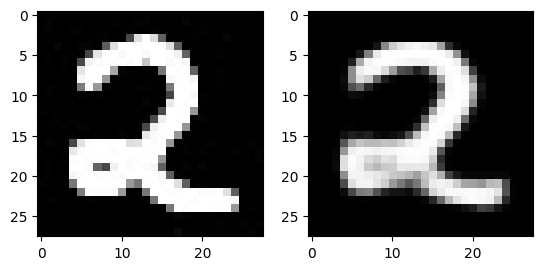

In [32]:
q = model(torch.tensor(1 - r, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0).to('cuda'))[0].reshape(28, 28, 1)
fig, axes = plt.subplots(1, 2)
axes[0].imshow(1 - r, cmap='gray')
axes[1].imshow(q.cpu().detach(), cmap='gray')

In [34]:
b = PIL.Image.open("C://Users//qw4rd//Downloads//Statprac//images//my2bad.jpg")
b = np.array(b.convert(mode="L")).reshape(28,28,1) / 255

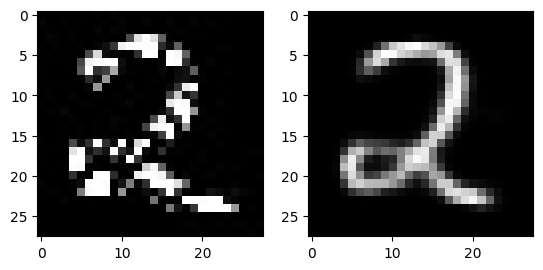

In [39]:
qb = model(torch.tensor(1 - b, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0).to('cuda'))[0].reshape(28, 28, 1)
fig, axes = plt.subplots(1, 2)
axes[0].imshow(1 - b, cmap='gray')
axes[1].imshow(qb.cpu().detach(), cmap='gray')

In [74]:
b = PIL.Image.open("C://Users//qw4rd//Downloads//Statprac//images//my2bad2.jpg")
b = np.array(b.convert(mode="L")).reshape(28,28,1) / 255

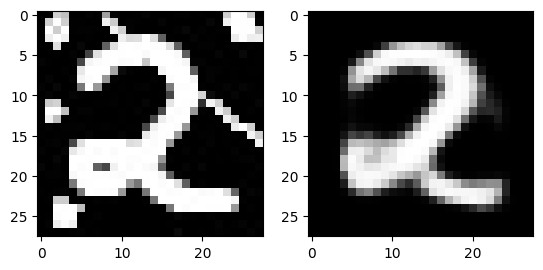

In [75]:
qb = model(torch.tensor(1 - b, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0).to('cuda'))[0].reshape(28, 28, 1)
fig, axes = plt.subplots(1, 2)
axes[0].imshow(1 - b, cmap='gray')
axes[1].imshow(qb.cpu().detach(), cmap='gray')

## 6. Заключение

Я подробно рассмотрел теорию вариационных автоэнкодеров, начиная с основ обычных автоэнкодеров. Разобрал ключевые компоненты VAE: вероятностный энкодер, репараметризационный трюк, декодер и функцию потерь ELBO (ошибка реконструкции + KL-дивергенция).

Был реализован VAE с использованием PyTorch, обучил его на данных MNIST и продемонстрировал его основные возможности:
* **Реконструкция:** Способность восстанавливать входные изображения (а также убирать аномалии).
* **Структурированное латентное пространство:** (Визуализация показала кластеризацию цифр). KL-дивергенция помогла организовать это пространство.
* **Генерация:** Способность создавать новые, правдоподобные изображения путем сэмплирования из латентного пространства.

VAE - мощный инструмент в области генеративного моделирования и обучения представлений.